# D.4. Dimension Reduction - Portfolio Mgmt via Regression

## Module: Risk

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

# Import Packages, Settings

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA

In [3]:
import os
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

# Import and Organize Data
### Data Source: Yahoo Finance

In [4]:
#from statsmodels.regression.quantile_regression import QuantReg
#from sklearn.linear_model import QuantileRegressor

#from scipy.optimize import lsq_linear

#import yfinance as yf

## Get Data

- Try using the data from HW#1, related to the Harvard Endowment.
- Or try a handful of equities downloaded from Yahoo.

In [5]:
DATAPATH = '../data/multi_asset_etf_data.xlsx'

info = pd.read_excel(DATAPATH,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(DATAPATH,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(DATAPATH,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

rets_Harvard, retsx_Harvard = rets, retsx

In [6]:
DATAPATH = '../data/commodities_return_data.xlsx'

rets_Commodities = pd.read_excel(DATAPATH,sheet_name='total returns')
rets_Commodities.set_index('Date',inplace=True)
retsx_Commodities = pd.read_excel(DATAPATH,sheet_name='excess returns')
retsx_Commodities.set_index('Date',inplace=True)

In [7]:
DATAPATH = '../data/equity_data.xlsx'

rets = pd.read_excel(DATAPATH,sheet_name='total returns')
rets.set_index('Date',inplace=True)
retsx = pd.read_excel(DATAPATH,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

Number of assets: 26
Number of periods: 350


,AAPL,BA,BAC,BAM,CAT,CVX,DHI,DHR,DIS,F,FDX,GE,HD,HON,JNJ,JPM,LOW,MCD,MMM,MSFT,NUE,NYT,SPY,TM,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-02-28 00:00:00,-10.95%,-2.01%,-0.69%,2.95%,3.12%,6.88%,2.22%,-9.31%,-2.96%,-0.76%,-0.66%,-2.54%,-2.52%,14.59%,-3.13%,-0.53%,2.95%,4.10%,8.29%,-3.83%,8.91%,-1.46%,0.85%,1.45%,-0.41%,5.08%
1993-03-31 00:00:00,-3.08%,1.57%,2.62%,12.06%,1.69%,7.70%,-0.25%,11.87%,0.03%,13.10%,-0.25%,6.48%,-0.79%,0.89%,0.04%,0.26%,18.61%,4.19%,3.54%,10.69%,5.76%,7.61%,1.99%,15.05%,-2.46%,3.68%
1993-04-30 00:00:00,-0.73%,8.33%,-9.39%,-4.19%,17.17%,3.37%,9.28%,-0.24%,-8.54%,5.85%,-14.43%,1.44%,-11.18%,-2.30%,2.11%,-5.50%,-9.97%,-9.22%,1.36%,-7.81%,-1.74%,-7.12%,-2.80%,19.67%,-15.99%,-0.43%
1993-05-31 00:00:00,10.50%,4.73%,-4.46%,7.13%,3.21%,3.16%,8.48%,12.73%,7.76%,-5.24%,1.07%,2.12%,9.25%,2.54%,2.67%,0.11%,23.55%,3.16%,1.99%,8.11%,-3.12%,0.70%,2.48%,-3.78%,3.99%,0.13%
1993-06-30 00:00:00,-30.49%,-6.87%,5.06%,3.86%,4.29%,-0.68%,-2.25%,2.22%,-7.64%,0.23%,-5.10%,3.68%,-5.59%,-0.25%,-7.25%,7.11%,3.39%,-1.29%,-4.57%,-5.24%,-2.87%,-15.83%,0.11%,-5.48%,-5.97%,0.70%


MIN Correlation pair is ('TM', 'JNJ')
MAX Correlation pair is ('XOM', 'CVX')


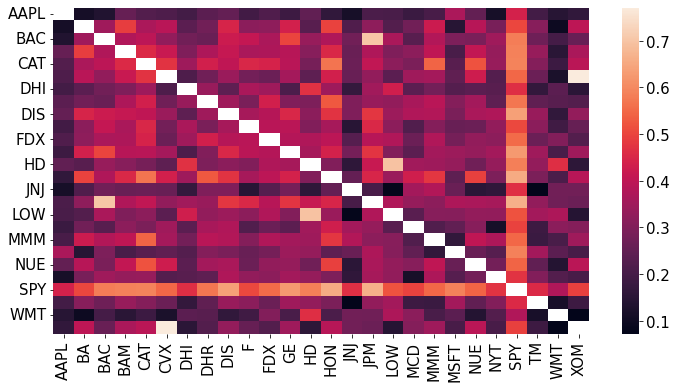

In [8]:
Ntime, Nassets = retsx.shape
print(f'Number of assets: {Nassets:.0f}')
print(f'Number of periods: {Ntime:.0f}')
display(retsx.head().style.format('{:.2%}'.format))
display_correlation(retsx)

## Figure of Mean-Variance Optimization

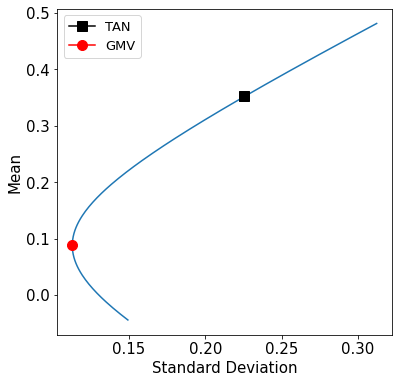

In [9]:
import os
import sys
if os.path.isfile('../dev/extras.py'):
    sys.path.insert(0, '../dev')
    from extras import MVweights, plotMV

    figrets = rets
    label = 'GMV'
    wstar = pd.DataFrame(MVweights(figrets,target=label),index=figrets.columns,columns=[label])
    label = 'TAN'
    wstar[label] = MVweights(figrets,target=label,isexcess=False)
    
    wts_a = wstar['TAN']
    wts_b = wstar['GMV']
    fig = plotMV(wts_a,wts_b,figrets.mean(),figrets.cov(),labels=['TAN','GMV'],annualize=12)

### Description of Individual Asset Sharpe Ratios

In [10]:
(retsx.mean()/retsx.std()).to_frame().describe().rename({0:'Sharpe Ratio Summary'},axis=1).drop(index=['count']).style.format('{:.2%}'.format)

,Sharpe Ratio Summary
mean,14.28%
std,4.52%
min,6.20%
25%,12.01%
50%,13.14%
75%,17.53%
max,24.15%


# Mean-Variance Optimization is OLS

## OLS when Projecting a Constant

The OLS estimator of regressing $y$ on $X$ (no intercept) is:
$$\boldsymbol{\hat{\beta}_{y|x}} = \left(\boldsymbol{X}'\boldsymbol{X}\right)^{-1}\boldsymbol{X}'\boldsymbol{y}$$
Though it may seem unusual we could regress a constant on regressors:
$$1 = \beta x_t + \epsilon_t$$
_Obviously, if we included an intercept, the regression would be degenerate with $\alpha=1, \beta=0, \epsilon_t=0$._

Regress the constant, 1, on returns. So $X=R$ and $y=1$.
$$\boldsymbol{\hat{\beta}_{1|R}} = \left(\boldsymbol{R}'\boldsymbol{R}\right)^{-1}\boldsymbol{R}'\boldsymbol{1}_{T\times 1}$$
where 
$\boldsymbol{1}_{T}$ denotes the $T\times 1$ vector of ones.

### The OLS solution as sample moments
$$\boldsymbol{\hat{\beta}_{1|R}} = \boldsymbol{\hat{\Sigma}_0^{-1}\hat{\mu}}$$ 

**Scaling**

The OLS betas will not sum to one, but we can include a scaling factor to ensure this, and we can refer to this as a weight vector, $\boldsymbol{w}_{ols}$:
$$\boldsymbol{w}_{ols} = \boldsymbol{\hat{\Sigma}_0^{-1}\hat{\mu}}\ \hat{c}_{ols}$$

$$\hat{c}_{ols} = \frac{1}{\boldsymbol{1}_{N}'\boldsymbol{\hat{\Sigma}}_0^{-1}\boldsymbol{\hat{\mu}}}$$
where $\boldsymbol{1}_{N}$ denotes a $N\times 1$ vector of ones.

## Mean-Variance Solution

Using sample estimates for the moments above, we have:
$$\boldsymbol{\hat{w}}_{tan} = \boldsymbol{\hat{\Sigma}^{-1}\hat{\mu}}\hat{c}_{tan}$$

$$\hat{c}_{\text{tan}} = \frac{1}{\boldsymbol{1_k'\hat{\Sigma}^{-1}\hat{\mu}}}$$

where $\hat{c}_{\text{mv}}$ is a constant that ensures $\boldsymbol{\hat{w}}_{tan}$ sums to 1. 

## Equality

If we go through the tedious linear algebra, we find
$$\boldsymbol{\hat{w}}_{tan} = 
\boldsymbol{\hat{\Sigma}}^{-1}\boldsymbol{\hat{\mu}}\hat{c}_{tan} =
\boldsymbol{\hat{\Sigma}}_0^{-1}\boldsymbol{\hat{\mu}}\hat{c}_{ols} = \boldsymbol{\hat{w}}_{ols}$$


## Scaling of the constant used as the dependent variable
- We are using the constant $1$ on the left-hand-side as the dependent variable.
- For OLS, the scaling of this constant simply changes the sum of the weights. Thus, it impacts the exact scaling constant, $\hat{c}_{ols}$, which enforces the weights to sum to 1.

### Going beyond MV, the scaling may matter!
- For more complex optimization, the solution weights do not scale proportionally with the target mean, as they do for the excess-return Mean-Variance frontier.
- In those cases, we may need to rescale the regressand constant to trace out the frontier.

## Conclusion
**Mean Variance Optimization is equivalent to OLS of a constant on the returns.**

This means...
- We can get statistical significance of the MV weights.
- We can restrict the MV solution in ways we commonly restrict OLS. This includes Non-Negative Least Squares.
- We can restrict the number of positions in the MV solution. (LASSO).
- We can restrict the position sizes in the MV solution via a penalty parameter instead of $2n$ boundary constraints. (Ridge).

In [11]:
wts = tangency_weights(retsx).rename({0:'MV'},axis=1)

# for OLS, doesn't matter what scaling we give y, just use y=1
# but note that below this scaling may matter
y = np.ones((Ntime,1))
X = retsx

beta = LinearRegression(fit_intercept=False).fit(X,y).coef_.transpose()
# rescale OLS beta to sum to 1
beta /= beta.sum()

wts['OLS'] = beta
wts.style.format('{:.2%}'.format)

,MV,OLS
AAPL,26.26%,26.26%
BA,13.98%,13.98%
BAC,-4.33%,-4.33%
BAM,51.14%,51.14%
CAT,12.45%,12.45%
CVX,10.86%,10.86%
DHI,5.71%,5.71%
DHR,56.00%,56.00%
DIS,1.66%,1.66%
F,-6.07%,-6.07%


### Confirmation
- They are the same weights!
- So we drop the redundant `OLS` column.

### Statistical Significance (in-sample) of these weights
Get them from the usual OLS t-stats!

In [12]:
tstats = pd.DataFrame(sm.OLS(y, X).fit().tvalues,columns=['t-stat'])
display(tstats.loc[tstats['t-stat'].abs()>2].sort_values('t-stat',ascending=False).style.format('{:.2f}'.format))

,t-stat
MSFT,2.58
BAM,2.49
DHR,2.48
JNJ,2.46
AAPL,2.37
SPY,-3.59


# No Short Positions

Implement via Non-Negative Least Squares (NNLS)
- Do this instead of using Constrained Optimization with $k$ boundary constraints.
- NNLS is doing the Linear Programming with inequalities the same as we would do with Constrained Optimization, but it saves us some work in implementation.

In [13]:
# for NLLS, scaling of y does not matter

y = np.ones((Ntime,1))
X = retsx

beta = LinearRegression(fit_intercept=False, positive=True).fit(X,y).coef_.transpose()
beta /= beta.sum()
beta

wts['NNLS'] = beta
wts.loc[wts['NNLS']>0, ['NNLS']].sort_values('NNLS',ascending=False).style.format('{:.2%}'.format)

,NNLS
DHR,22.01%
JNJ,21.49%
BAM,19.06%
LOW,11.72%
AAPL,9.76%
MSFT,9.13%
MCD,6.82%


# Regularized Regressions are Useful

The OLS interpretation of MV makes clear that due to multicolinearity, the optimal in-sample weights can be extreme.

Instead, we may want to use regularized regression to deal with the following constraints.

**Constraints**
1. restrict gross leverage, $\sum_{i}^n |w^i| \le L$
2. limit the total number of positions, $\sum_{i}^n\mathbb{1}_{\ne0}\left(w^i\right) \le K$

- where $\mathbb{1}_{\ne0}\left(w^i\right)$ denotes the indicator function, equal to 1 if $w^i\ne 0$ and equal to 0 if $w^i=0$.

This can be done somewhat clumsily with the traditional constrained optimization.

But other challenges are hard to address with traditional techniques

**Challenges**
1. Limit positions from being too large, without specifying security-specific boundaries.
1. Put more emphasis on out-of-sample performance
1. Implement a Bayesian approach to Mean-Variance optimization

## Ridge Estimation

- Ridge estimation may help with the challenges above.
- Except it will NOT limit the total number of positions.

The Ridge estimator is the optimized solution for a regularized regression with an L2 penalty.

Recall that the Ridge estimator is 
$$\hat{\boldsymbol{\beta}}^{\text{ridge}} = \left(\boldsymbol{X}'\boldsymbol{X} + \lambda\mathcal{I}_n\right)^{-1}\boldsymbol{X}'\boldsymbol{y}$$
where
- $\mathcal{I}_n$ is the $n\times n$ identity matrix.
- $\lambda$ is a hyperparameter ("tuning" parameter) related to the L2 penalty.

Note that this is the exact same as OLS, except we have a modified second-moment matrix. In our application of regressing 1 on returns without an intercept, the point is that instead of the OLS calculation,
$$\boldsymbol{\hat{\Sigma}}_0^{-1}\boldsymbol{\hat{\mu}}$$
we use 
$$\left(\boldsymbol{\hat{\Sigma}}_0 + \lambda\mathcal{I}_n\right)^{-1}\boldsymbol{\hat{\mu}}$$
- For $\lambda=0$, we simply have OLS.
- For large $\lambda$, we are diagonalizing the second-moment matrix. (Since we do not regress on an intercept, this is the uncentered second-moment matrix, not quite the covariance matrix.)

### Conclusion
- The Ridge estimator is diagonalizing the second-moment matrix, which makes it more stable for inversion.
- This reduces its sensitivity to small changes in the data, and allows it to perform more consistently out-of-sample, though less optimally in-sample.
- Conceptually, this means that it constructs less extreme long-short weights given that it diminishes the magnitudes of the correlations relative to the main diagonal.
- Statistically, the extra term on the second-moment matrix is reducing the impact the multicolinearity of the asset returns have on the estimate.

## LASSO Estimation

- LASSO estimation helps with the challenges above.
- Additionally, LASSO can reduce the number of positions, (dimension reduction.)

Unlike Ridge, there is no closed-form solution for the LASSO estimator.

## Bayesian Interpretation

**Ridge**
- The Ridge estimator is a Bayesian posterior assuming a Normally distributed prior on the betas, updated via normally distributed sample data.

**LASSO**
- The LASSO estimator is a Bayesian posterior assuming a Laplace-distributed prior on the betas, updated via normally distributed sample data.

This does not mean Ridge requires us to believe the data is normally distributed. That is an assumption to interpret it as thte Bayesian solution.

Figure 6.2 from *Introduction to Statistical Learning* (James, Witten, Hastie, and Tibshirani) gives a useful visualization of these priors, and why they lead to Ridge having muted, but non-zero betas, whereas LASSO has (potentially many) betas equal to zero and others that are not muted as much as in Ridge.
<img src="../refs/regularized_bayesian_priors.png" width="400"/>

*If figure does not display, make sure you have the `refs` directory in the repo, at the expected relative path.*


In [14]:
def penalized_reg_limit_gross(func, X, y, limit=2, penalty=1e-6, fit_intercept=True):
    wts = np.ones(X.shape[1]) * 100
    
    while np.abs(wts).sum()>limit:
        penalty *= 1.25
        model = func(alpha=penalty, fit_intercept=fit_intercept).fit(X,y)
        wts = model.coef_ / model.coef_.sum()
    
    return wts, penalty

In [15]:
GROSS_LIMIT = 2
if wts['MV'].abs().sum()<2:
    GROSS_LIMIT = 1.25

# scaling of y will impact the solution if penalty held constant
# here, we adjust the penalty to ensure the scaling, so initial scaling of y is less important

betas, penalty_ridge = penalized_reg_limit_gross(Ridge, rets, y, limit=GROSS_LIMIT, fit_intercept=False)
wts['Ridge'] = betas.transpose()
betas, penalty_lasso = penalized_reg_limit_gross(Lasso, rets, y, limit=GROSS_LIMIT, fit_intercept=False)
wts['Lasso'] = betas.transpose()

print(f'Penalty for Ridge: {penalty_ridge : .2e}.\nPenalty for LASSO: {penalty_lasso : .2e}.')

Penalty for Ridge:  6.53e-01.
Penalty for LASSO:  1.58e-03.


## Diagonalization and Shrinkage

### Diagonalization
- Diagonalize the covariance matrix (set all off-diagonal terms to 0).
- This was popular long before Ridge and continues to be.

### Shrinkage Estimators
- "Shrink" the covariance matrix going into MV estimation by mixing a diagonalized version of the matrix with the full matrix, according to some mixing parameter.
- The mixing parameter may change over time, depending on the data.
- This is equivalent to Ridge for certain specification of the mixing parameter.

So Ridge is another lense for a popular approach to MV optimization.

In [16]:
covDiag = np.diag(np.diag(retsx.cov()))
temp = np.linalg.solve(covDiag,retsx.mean())
wts['Diagonal'] = temp / temp.sum()

# Performance

In [17]:
if 'Equal' not in wts.columns:
    wts.insert(0,'Equal',np.ones_like(Nassets)/Nassets)
if 'OLS' in wts.columns:
    wts.drop(columns=['OLS'],inplace=True)

retsx_ports = retsx @ wts

In [18]:
display(performanceMetrics(retsx_ports, annualization=12).style.format('{:.2%}'.format))
display(tailMetrics(retsx_ports))
display(get_ols_metrics(retsx['SPY'], retsx_ports,annualization=12).style.format('{:.2%}'.format))

,Mean,Vol,Sharpe,Min,Max
Equal,13.51%,16.45%,82.14%,-17.65%,18.85%
MV,41.61%,28.23%,147.40%,-21.62%,34.39%
NNLS,18.34%,15.94%,115.03%,-15.59%,16.18%
Ridge,20.04%,15.86%,126.36%,-12.24%,19.93%
Lasso,20.97%,16.64%,126.02%,-13.36%,20.66%
Diagonal,13.82%,15.19%,90.94%,-15.54%,13.22%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
Equal,-0.3863,1.9216,-0.0645,-0.1048,-0.5053,2007-05-31,2009-02-28,2010-04-30,1065 days
MV,0.2311,1.0423,-0.0980,-0.1370,-0.4377,1999-08-31,2000-02-29,2001-01-31,519 days
NNLS,-0.3822,0.7229,-0.0630,-0.0919,-0.4279,2007-10-31,2009-02-28,2010-04-30,912 days
Ridge,-0.1658,0.9676,-0.0634,-0.0865,-0.2713,2008-08-31,2009-02-28,2010-03-31,577 days
Lasso,-0.1832,0.7954,-0.0673,-0.0910,-0.3359,2007-10-31,2009-02-28,2010-03-31,882 days
Diagonal,-0.4767,1.4038,-0.0612,-0.0958,-0.4442,2007-10-31,2009-02-28,2010-04-30,912 days


,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
Equal,4.35%,104.56%,86.16%,12.92%,71.13%
MV,34.72%,78.69%,16.56%,52.88%,134.64%
NNLS,10.19%,93.06%,72.66%,19.70%,122.21%
Ridge,12.77%,83.02%,58.41%,24.14%,124.85%
Lasso,13.37%,86.81%,58.02%,24.16%,123.97%
Diagonal,5.26%,97.69%,88.15%,14.14%,100.57%


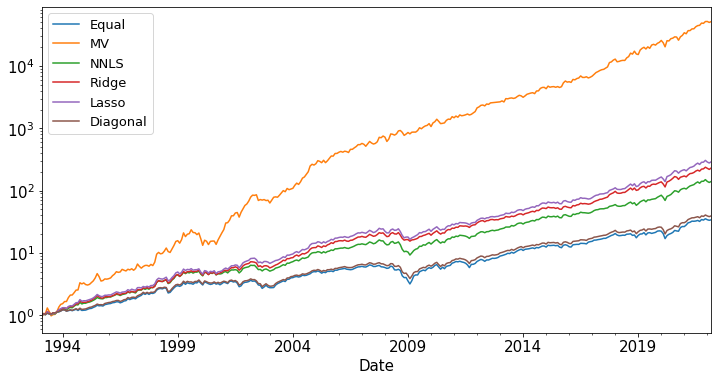

In [19]:
(1+retsx_ports).cumprod().plot(logy=True);

In [20]:
retsx_ports.corr().style.format('{:.2%}'.format)

,Equal,MV,NNLS,Ridge,Lasso,Diagonal
Equal,100.00%,55.73%,86.66%,78.54%,78.15%,98.97%
MV,55.73%,100.00%,78.04%,85.73%,85.50%,61.70%
NNLS,86.66%,78.04%,100.00%,95.36%,97.71%,91.06%
Ridge,78.54%,85.73%,95.36%,100.00%,98.18%,84.93%
Lasso,78.15%,85.50%,97.71%,98.18%,100.00%,84.34%
Diagonal,98.97%,61.70%,91.06%,84.93%,84.34%,100.00%


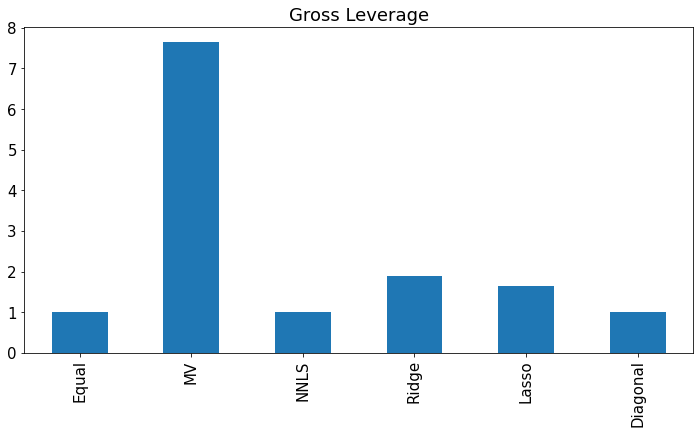

In [21]:
wts.abs().sum().plot.bar(title='Gross Leverage');

In [22]:
wts.style.format('{:.2%}'.format)

,Equal,MV,NNLS,Ridge,Lasso,Diagonal
AAPL,3.85%,26.26%,9.76%,10.52%,10.74%,3.04%
BA,3.85%,13.98%,0.00%,5.04%,0.00%,2.73%
BAC,3.85%,-4.33%,0.00%,-3.53%,-0.52%,1.66%
BAM,3.85%,51.14%,19.06%,19.67%,24.92%,6.08%
CAT,3.85%,12.45%,0.00%,4.68%,0.00%,3.54%
CVX,3.85%,10.86%,0.00%,4.83%,1.00%,4.74%
DHI,3.85%,5.71%,0.00%,3.26%,1.17%,2.55%
DHR,3.85%,56.00%,22.01%,20.69%,25.32%,7.14%
DIS,3.85%,1.66%,0.00%,-4.05%,-0.00%,2.92%
F,3.85%,-6.07%,0.00%,-4.84%,-2.98%,1.23%


***

# Performance Out-of-Sample

In [23]:
%%time
ADJUST_PENALTY = True
GROSS_LIMIT = 2

minT = 12*10
methods = ['SPY','Equal','MV','NNLS', 'Ridge','Lasso']

# initialize
wts_oos = pd.concat([pd.DataFrame(index=rets.index, columns=rets.columns)]*len(methods), keys=methods, axis=1)
equal_wts = np.ones(Nassets) / Nassets

for t in wts_oos.index:    
    R = retsx.loc[:t,:]
    y = np.ones(R.shape[0])
    
    if R.shape[0] >= minT:
        wts_oos.loc[t,'Equal',] = equal_wts
        if 'SPY' in R.columns:
            wts_oos.loc[t,'SPY',] = 0
            wts_oos.loc[t,('SPY','SPY')] = 1
        
        wts_oos.loc[t,'MV',] = LinearRegression(fit_intercept=False).fit(R,y).coef_
        wts_oos.loc[t,'NNLS',] = LinearRegression(positive=True, fit_intercept=False).fit(R,y).coef_    
        wts_oos.loc[t,'Ridge',] = Ridge(alpha= penalty_ridge, fit_intercept=False).fit(R,y).coef_
        wts_oos.loc[t,'Lasso',] = Lasso(alpha= penalty_lasso, fit_intercept=False).fit(R,y).coef_

        # dynamically adjust the penalty parameter
        # takes longer to run, brings gross leverage down
        if ADJUST_PENALTY:
            betas, penalty_ridge = penalized_reg_limit_gross(Ridge, R, y, limit=GROSS_LIMIT, fit_intercept=False)
            betas, penalty_lasso = penalized_reg_limit_gross(Lasso, R, y, limit=GROSS_LIMIT, fit_intercept=False)

for method in methods:
    div_factor = wts_oos[method].sum(axis=1)
    div_factor[div_factor==0] = 1
    wts_oos[method] = wts_oos[method].div(div_factor, axis='rows')

wts_oos_lag = wts_oos.shift(1)

CPU times: user 35.3 s, sys: 2.11 s, total: 37.4 s
Wall time: 30.3 s


In [24]:
retsx_port_oos = pd.DataFrame(index=retsx.index, columns = methods)

for method in methods:    
    retsx_port_oos[method] = (wts_oos_lag[method] * retsx).sum(axis=1)

# do not count burn-in period
retsx_port_oos.iloc[:minT,:] = None

In [25]:
display(performanceMetrics(retsx_port_oos, annualization=12).style.format('{:.2%}'.format))
display(tailMetrics(retsx_port_oos))
display(get_ols_metrics(retsx['SPY'], retsx_port_oos,annualization=12).style.format('{:.2%}'.format))

,Mean,Vol,Sharpe,Min,Max
SPY,10.51%,14.20%,74.07%,-16.60%,12.70%
Equal,14.52%,16.54%,87.77%,-17.65%,18.85%
MV,18.02%,28.22%,63.85%,-29.95%,26.13%
NNLS,14.85%,14.93%,99.46%,-16.59%,16.02%
Ridge,13.85%,16.12%,85.93%,-13.23%,20.60%
Lasso,15.21%,17.75%,85.68%,-14.44%,23.51%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
SPY,-0.6270,1.8807,-0.0678,-0.0936,-0.5194,2007-05-31,2009-02-28,2012-09-30,1949 days
Equal,-0.3327,2.4487,-0.0639,-0.1054,-0.5053,2007-05-31,2009-02-28,2010-04-30,1065 days
MV,-0.5161,2.0686,-0.1096,-0.1882,-0.6327,2009-01-31,2010-01-31,2014-10-31,2099 days
NNLS,-0.5592,1.5421,-0.0620,-0.0899,-0.4477,2007-10-31,2009-02-28,2011-04-30,1277 days
Ridge,-0.2970,1.2916,-0.0714,-0.0959,-0.4547,2007-10-31,2009-05-31,2012-04-30,1643 days
Lasso,-0.1853,1.3283,-0.0779,-0.1044,-0.4710,2007-10-31,2010-01-31,2013-01-31,1919 days


,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
SPY,-0.00%,100.00%,100.00%,8.76%,nan%
Equal,2.90%,110.49%,89.89%,13.14%,55.20%
MV,12.79%,49.70%,6.25%,36.25%,46.82%
NNLS,4.92%,94.42%,80.58%,15.73%,74.82%
Ridge,4.72%,86.84%,58.46%,15.95%,45.46%
Lasso,5.95%,88.08%,49.63%,17.26%,47.20%


In [26]:
wts_all = wts_oos.unstack().groupby(level=(0,2))
wts_all_diff = wts_oos.diff().unstack().groupby(level=(0,2))

gross_leverage = wts_all.apply(lambda x: sum(abs(x))).unstack(level=0)
turnover = wts_all_diff.apply(lambda x: sum(abs(x))).unstack(level=0)
num_positions = wts_all.apply(lambda x: sum(abs(x)>0)).unstack(level=0)
max_wt = wts_all.apply(lambda x: max(x)).unstack(level=0)
min_wt = wts_all.apply(lambda x: min(x)).unstack(level=0)

dates_active = (rets.index[minT],rets.index[-1])

,SPY,Equal,MV,NNLS,Ridge,Lasso
SPY,100.00%,94.81%,25.00%,89.77%,76.46%,70.45%
Equal,94.81%,100.00%,25.68%,86.16%,68.54%,61.52%
MV,25.00%,25.68%,100.00%,54.50%,70.70%,73.37%
NNLS,89.77%,86.16%,54.50%,100.00%,89.87%,88.46%
Ridge,76.46%,68.54%,70.70%,89.87%,100.00%,96.34%
Lasso,70.45%,61.52%,73.37%,88.46%,96.34%,100.00%


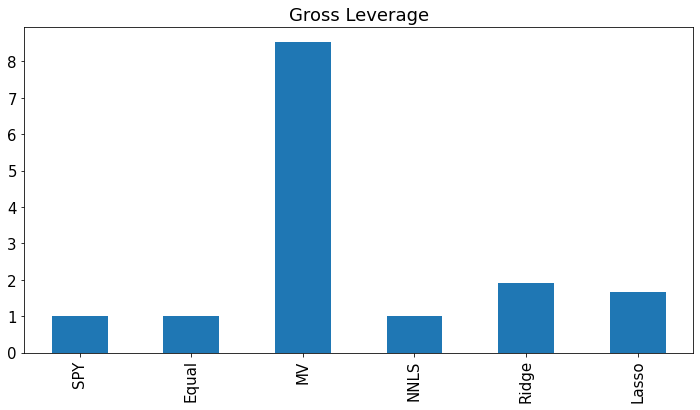

In [27]:
display(retsx_port_oos.corr().style.format('{:.2%}'.format))
gross_leverage.mean().plot.bar(title='Gross Leverage');

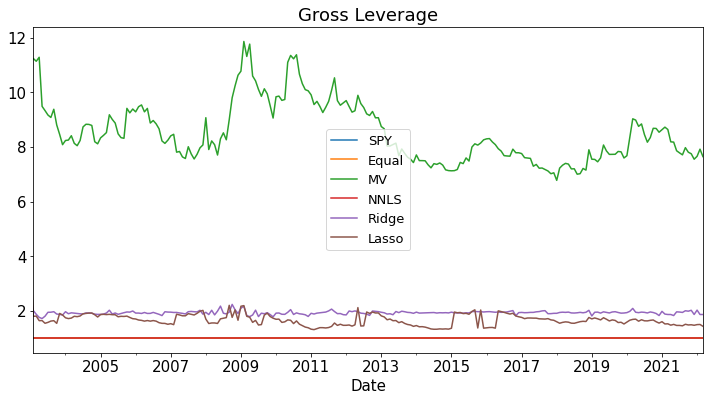

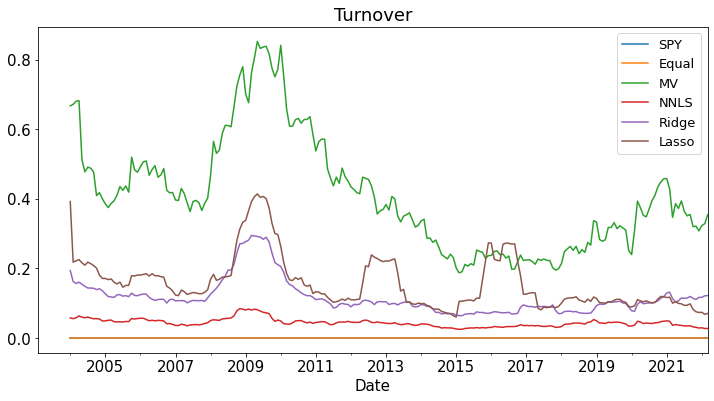

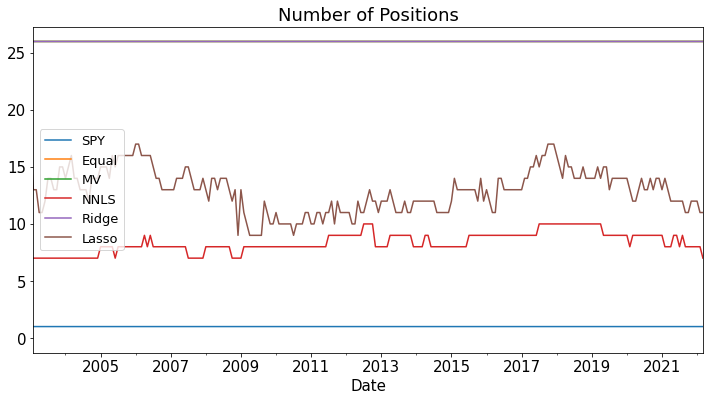

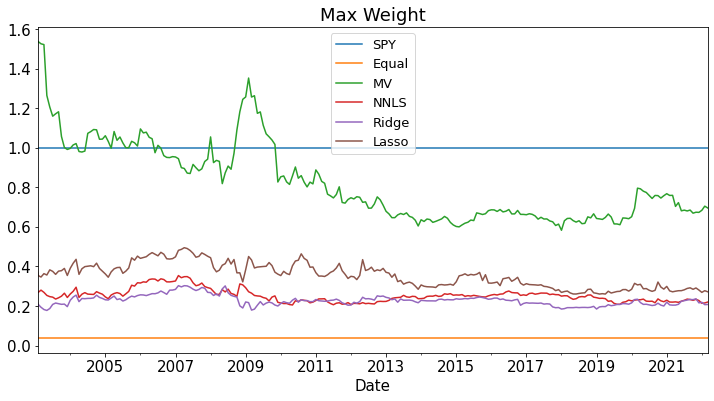

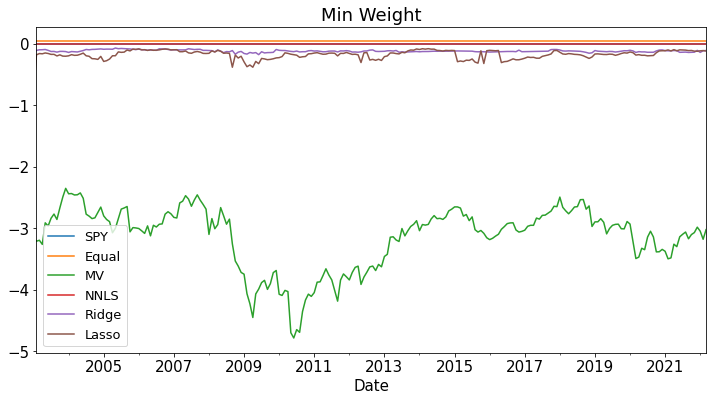

In [28]:
gross_leverage.plot(title='Gross Leverage',xlim=dates_active)
turnover.rolling(12*1).mean().plot(title='Turnover',xlim=dates_active)
plt.show()
num_positions.plot(title='Number of Positions',xlim=dates_active)
max_wt.plot(title='Max Weight',xlim=dates_active)
plt.show()
min_wt.plot(title='Min Weight',xlim=dates_active)
plt.show()